# 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import importlib
import json

from pathlib import Path

In [2]:
MAIN_DIR = Path.cwd().parent
DATA_DIR = MAIN_DIR / 'data'
EXP_DIR = MAIN_DIR / 'experiments'
NOTEBOOKS_DIR = MAIN_DIR / 'notebooks'
RESULTS_DIR = MAIN_DIR / 'results'
SRC_DIR = MAIN_DIR / 'src'

FIGURES_DIR = RESULTS_DIR / 'figures'

In [3]:
sys.path.append(str(SRC_DIR))

import data_preprocessing
importlib.reload(data_preprocessing)

from data_preprocessing import (
    clean_columns_and_extract_column_info,
    compute_cycle_durations,
    compute_population_stats,
    compute_lag_between_peaks
)


### 1.1 Importing the Raw Data

In [4]:
# Import all raw csv data files

raw_data_dir = DATA_DIR / 'raw'
data_files = sorted(raw_data_dir.glob('*.csv'), key=lambda x: int(x.stem.removeprefix('C')))

dfs = {f.stem: pd.read_csv(f) for f in data_files}
column_units_dict = {}  # Store units per dataset

# Clean column names and store the units of each column
for name, df in dfs.items():
    dfs[name], column_units_dict[name] = clean_columns_and_extract_column_info(df)

data = pd.concat(dfs.values(), ignore_index=True)

# Show basic information about the data
print(data.info())
print(300 * '-')
print(data.describe())
print(300 * '-')
display(data.head())

# Check for missing values
print('Number of NaN values per column:\n', data.isnull().sum())

# Column unit information
print('Column units:\n')
for dataset, units in column_units_dict.items():
    print(f'{dataset}:')
    print(f'{units}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             1953 non-null   float64
 1   algae            1930 non-null   float64
 2   rotifers         1927 non-null   float64
 3   egg-ratio        1912 non-null   float64
 4   eggs             1927 non-null   float64
 5   dead animals     1921 non-null   float64
 6   external medium  1953 non-null   float64
dtypes: float64(7)
memory usage: 106.9 KB
None
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              time        algae     rotifers    egg-ratio         eggs  \
count  1953.000000  1930.000000  1927.000000  1912.000000 

,time,algae,rotifers,egg-ratio,eggs,dead animals,external medium
0,0.00,1.50,NaN,NaN,NaN,NaN,80.0
1,0.95,0.83,5.42,0.00,0.00,0.4,80.0
2,2.26,0.70,18.26,0.38,7.02,0.0,80.0
3,2.91,0.38,17.86,0.19,3.41,0.4,80.0
4,3.95,0.41,21.07,0.32,6.82,0.4,80.0


Number of NaN values per column:
 time                0
algae              23
rotifers           26
egg-ratio          41
eggs               26
dead animals       32
external medium     0
dtype: int64
Column units:

C1:
{'time': 'days', 'algae': '10^6 cells/ml', 'rotifers': 'animals/ml', 'egg-ratio': None, 'eggs': 'per ml', 'dead animals': 'per ml', 'external medium': 'mu mol N / l'}
C2:
{'time': 'days', 'algae': '10^6 cells/ml', 'rotifers': 'animals/ml', 'egg-ratio': None, 'eggs': 'per ml', 'dead animals': 'per ml', 'external medium': 'mu mol N / l'}
C3:
{'time': 'days', 'algae': '10^6 cells/ml', 'rotifers': 'animals/ml', 'egg-ratio': None, 'eggs': 'per ml', 'dead animals': 'per ml', 'external medium': 'mu mol N / l'}
C4:
{'time': 'days', 'algae': '10^6 cells/ml', 'rotifers': 'animals/ml', 'egg-ratio': None, 'eggs': 'per ml', 'dead animals': 'per ml', 'external medium': 'mu mol N / l'}
C5:
{'time': 'days', 'algae': '10^6 cells/ml', 'rotifers': 'animals/ml', 'egg-ratio': None, 'eggs': 

In [5]:
# As the units are the same for all runs we just use the first one
column_units = column_units_dict['C1']

### 1.2 Handling Missing Values

Some of the rows in our data contain missing values marked as NaN. To not lose the missing values we linearly interpolate the missing values.

In [6]:
for name, df in dfs.items():
    df.interpolate(method='linear', inplace=True)
    df.ffill(inplace=True)
    df.bfill(inplace=True)

# Check for missing values again
data = pd.concat(dfs.values(), ignore_index=True)
print('Number of NaN values per column:\n', data.isnull().sum())

Number of NaN values per column:
 time               0
algae              0
rotifers           0
egg-ratio          0
eggs               0
dead animals       0
external medium    0
dtype: int64


### 1.3 Visualizing Single Runs

Our data consist of 10 files which each show a run of predator-prey dynamics of algae and rotifers. We want to visualize the population density of the two populations over time for the different runs.

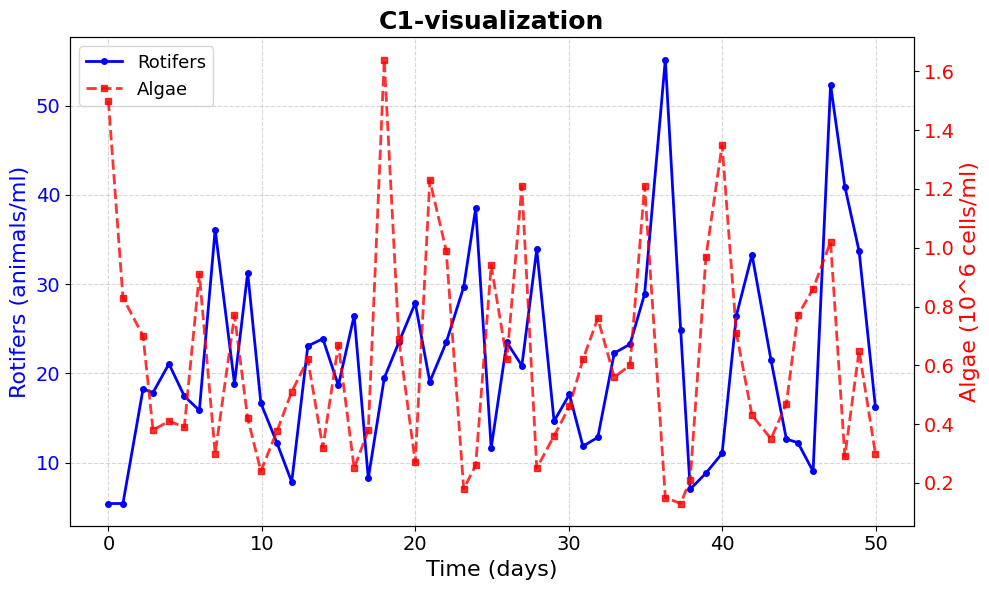

In [26]:
import matplotlib.pyplot as plt

def plot_single_run(df, units, time_period=None, title="Predator-Prey Dynamics", show=True, save=False):
    """
    Plot the predator-prey dynamics of a single run with enhanced aesthetics.
    
    Args:
        df (pd.DataFrame): DataFrame containing the predator-prey dynamics.
        units (dict): Dictionary containing the units of the columns.
        time_period (tuple): Tuple containing the start and end time for the plot.
        title (str): Title of the plot.
        show (bool): Whether to show the plot.
        save (bool): Whether to save the plot.
    """
    # Filter data based on the time period
    if time_period:
        df = df[(df["time"] >= time_period[0]) & (df["time"] <= time_period[1])]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Primary y-axis (Rotifers)
    color1 = "blue"
    ax1.set_xlabel(f"Time ({units['time']})", fontsize=16)
    ax1.set_ylabel(f"Rotifers ({units['rotifers']})", color=color1, fontsize=16)
    ax1.plot(df["time"], df["rotifers"], label="Rotifers", color=color1, linestyle="-", linewidth=2, marker="o", markersize=4)
    ax1.tick_params(axis="y", labelcolor=color1, labelsize=14)  # Increased tick label size
    ax1.tick_params(axis="x", labelsize=14)
    ax1.grid(True, linestyle="--", alpha=0.5)  # Light grid

    # Secondary y-axis (Algae)
    ax2 = ax1.twinx()
    color2 = "red"
    ax2.set_ylabel(f"Algae ({units['algae']})", color=color2, fontsize=16)
    ax2.plot(df["time"], df["algae"], label="Algae", color=color2, linestyle="--", linewidth=2, marker="s", markersize=4, alpha=0.8)
    ax2.tick_params(axis="y", labelcolor=color2, labelsize=14)

    # Title
    plt.title(title, fontsize=18, fontweight="bold")

    # Custom Legend Positioning (bottom right inside the plot)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=13, frameon=True)

    # Adjust layout
    fig.tight_layout()

    if save:
        plt.savefig(FIGURES_DIR / "1-data-exploration" / f"{title.replace(' ', '-')}.png", dpi=300, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close()

# Plot first dataset as an example in a time period of 50 days
first_key = list(dfs.keys())[0]
plot_single_run(dfs[first_key], column_units, time_period=(0, 50), title=f"{first_key}-visualization", show=True, save=False)


In [29]:
# Save the plots for all datasets
for key, df in dfs.items():
    plot_single_run(df, column_units, title=f"{key}-algae-rotifer-visualization", show=False, save=True)

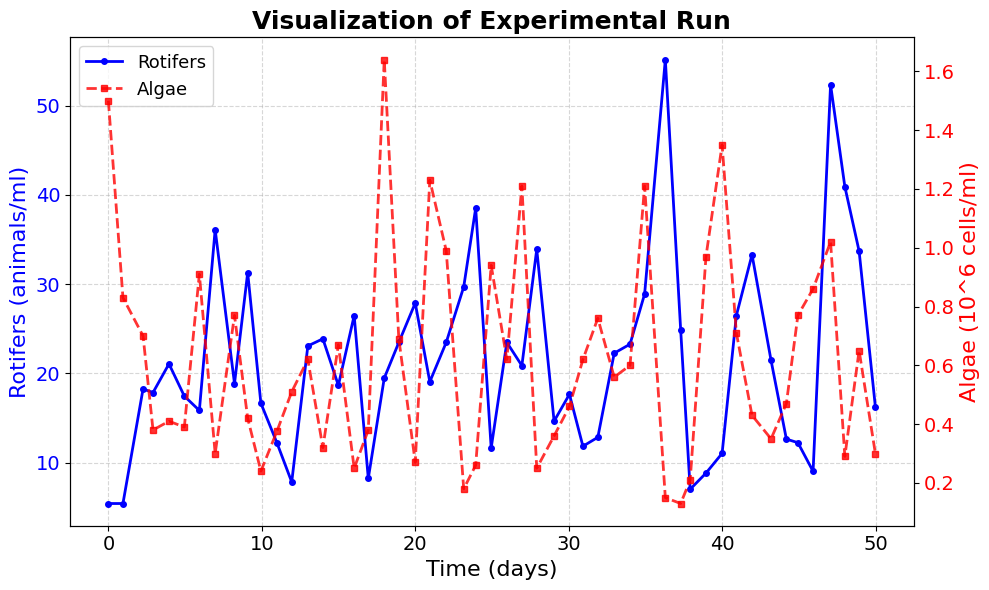

In [28]:
# Example run for visualization in report
plot_single_run(dfs['C1'], column_units, time_period=(0, 50), title="Visualization of Experimental Run", show=True, save=True)

Additionally we want to visualize how the population of eggs and dead animals behaves over time.

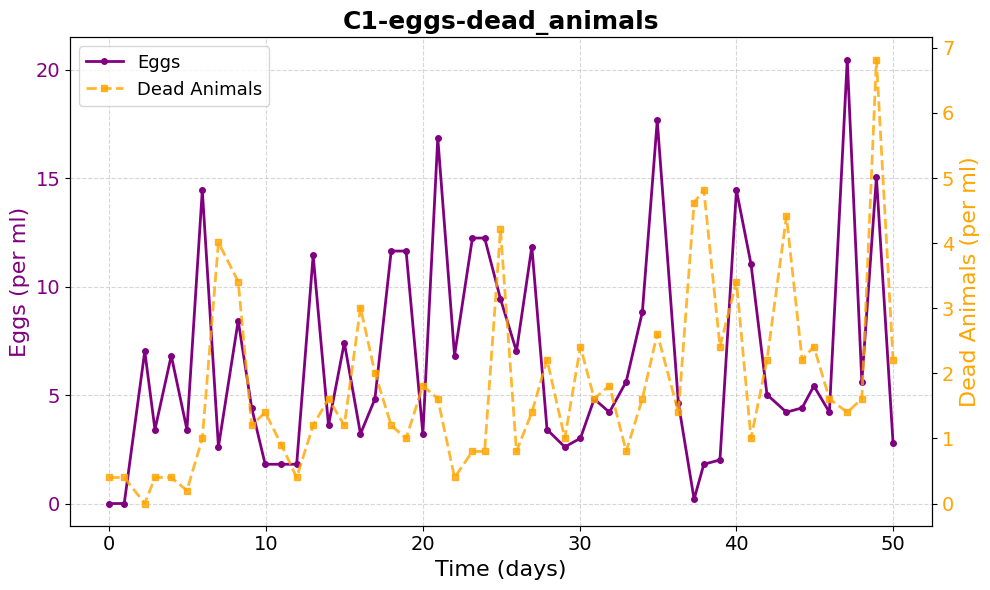

In [31]:
def plot_eggs_dead_animals(df, units, time_period=None, title="Eggs & Dead Animal Dynamics", show=True, save=False):
    """
    Plot the egg and dead animal population dynamics with enhanced aesthetics.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        units (dict): Dictionary containing the units of the columns.
        time_period (tuple): Tuple containing the start and end time for the plot.
        title (str): Title of the plot.
        show (bool): Whether to show the plot.
        save (bool): Whether to save the plot.
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Filter time period if needed
    if time_period:
        df = df[(df["time"] >= time_period[0]) & (df["time"] <= time_period[1])]

    # Primary y-axis (Eggs)
    color1 = "purple"
    ax1.set_xlabel(f"Time ({units['time']})", fontsize=16)
    ax1.set_ylabel(f"Eggs ({units['eggs']})", color=color1, fontsize=16)
    ax1.plot(df["time"], df["eggs"], label="Eggs", color=color1, linestyle="-", linewidth=2, marker="o", markersize=4)
    ax1.tick_params(axis="y", labelcolor=color1, labelsize=14)
    ax1.tick_params(axis="x", labelsize=14)
    ax1.grid(True, linestyle="--", alpha=0.5)  # Light grid

    # Secondary y-axis (Dead Animals)
    ax2 = ax1.twinx()
    color2 = "orange"
    ax2.set_ylabel(f"Dead Animals ({units['dead animals']})", color=color2, fontsize=16)
    ax2.plot(df["time"], df["dead animals"], label="Dead Animals", color=color2, linestyle="--", linewidth=2, marker="s", markersize=4, alpha=0.8)
    ax2.tick_params(axis="y", labelcolor=color2, labelsize=14)

    # Title
    plt.title(title, fontsize=18, fontweight="bold")

    # Custom Legend Placement
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=13, frameon=True)

    # Adjust layout
    fig.tight_layout()

    if save:
        plt.savefig(FIGURES_DIR / "1-data-exploration" / f"{title}.png", dpi=300, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close()

# Example: Plot for a single run
plot_eggs_dead_animals(dfs[first_key], column_units_dict[first_key], time_period=(0, 50), title=f"{first_key}-eggs-dead_animals", show=True, save=False)

In [32]:
# Save the plots for all datasets
for key, df in dfs.items():
    plot_eggs_dead_animals(df, column_units_dict[key], title=f"{key}-eggs-dead_animals", show=False, save=True)

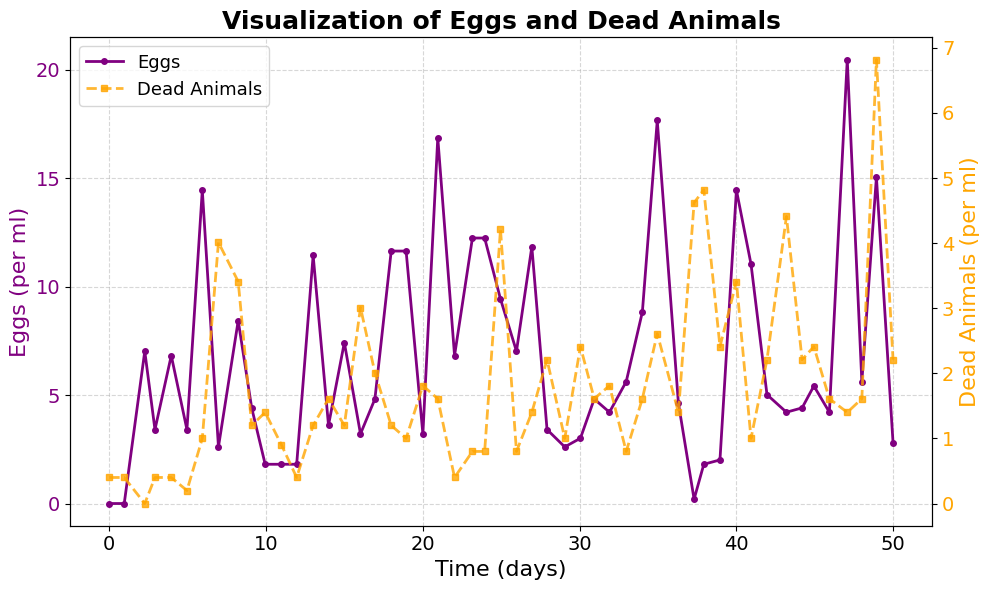

In [33]:
# Example run for visualization in report
plot_eggs_dead_animals(dfs['C1'], column_units, time_period=(0, 50), title="Visualization of Eggs and Dead Animals", show=True, save=True)

### 1.4 Showing Full Data Plot

We now show the full data in one plot where all concentrations are normalized. The full data includes the time series of algae (green), rotifers (red), eggs (black), egg ratio (blue) and dead animals (yellow).

In [33]:
def plot_full_data(df, time_period=None, title="Full Data Plot", show=True, save=False):
    plt.figure(figsize=(10, 5))

    # Filter time period if needed
    if time_period:
        df = df[(df["time"] >= time_period[0]) & (df["time"] <= time_period[1])]

    # Normalize values
    algae = df["algae"] / df["algae"].max()
    rotifers = df["rotifers"] / df["rotifers"].max()
    eggs = df["eggs"] / df["eggs"].max()
    egg_ratio = df["egg-ratio"] / df["egg-ratio"].max()
    dead_animals = df["dead animals"] / df["dead animals"].max()

    time = df["time"]

    # Plot with markers and lines
    plt.plot(time, algae, 'go-', label=f'Algae')
    plt.plot(time, rotifers, 'ro-', label=f'Rotifers')
    plt.plot(time, eggs, 'ko-', label=f'Eggs')
    plt.plot(time, egg_ratio, 'bo-', label=f'Egg Ratio')
    plt.plot(time, dead_animals, 'yo-', label=f'Dead Animals')


    plt.title(title)
    plt.xlabel(f"Time ({units['time']})")
    plt.ylabel("Normalized Values")
    plt.legend()
    plt.grid()

    if save:
        plt.savefig(FIGURES_DIR / "1-data-exploration" / f"{title}.png")

    if show:
        plt.show()
    else:
        plt.close()

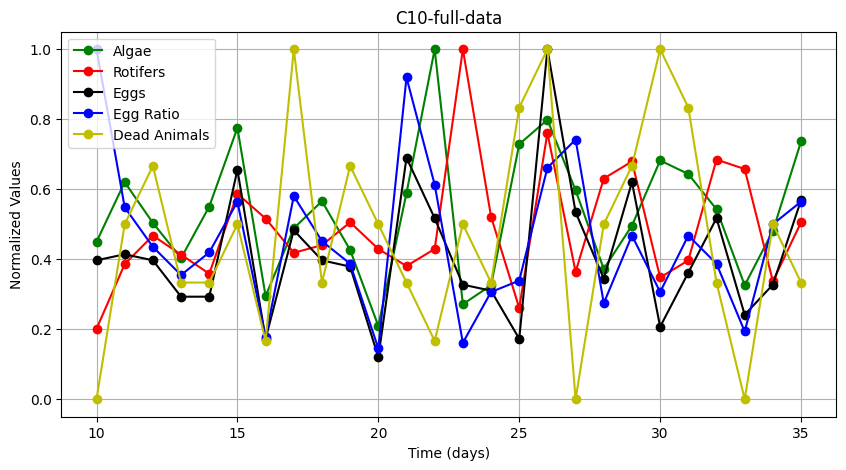

In [34]:
# Example: Plot for a single run
plot_full_data(dfs['C10'], time_period=(10, 35), title=f"C10-full-data", show=True, save=False)

In [35]:
# Save the full data for all runs
for key, df in dfs.items():
    plot_full_data(df, title=f"{key}-full-data", show=False, save=True)

### 1.5 Computing Key Metrics

We want to compute some key metrics of the data to better understand the predator-prey cycle. For that we focus on cycle duration, mean and variability, peak detection, and lag between peaks. The summary results are saved 

In [36]:
cycle_metrics = {name: compute_cycle_durations(df) for name, df in dfs.items()}
pop_stats = {name: compute_population_stats(df) for name, df in dfs.items()}
lag_metrics = {name: compute_lag_between_peaks(df) for name, df in dfs.items()}

# Collect all metrics into a structured format
summary_data = []
for name in dfs.keys():
    summary_data.append({
        "Run": name,
        "Algae Cycle (days)": cycle_metrics[name]["avg_algae_cycle"],
        "Rotifer Cycle (days)": cycle_metrics[name]["avg_rotifer_cycle"],
        "Eggs Cycle (days)": cycle_metrics[name]["avg_eggs_cycle"],
        "Dead Animal Cycle (days)": cycle_metrics[name]["avg_dead_cycle"],
        f"Mean Algae ({column_units['algae']})": pop_stats[name]["mean_algae"],
        f"Std Algae ({column_units['algae']})": pop_stats[name]["std_algae"],
        f"Mean Rotifers ({column_units['rotifers']})": pop_stats[name]["mean_rotifers"],
        f"Std Rotifers ({column_units['rotifers']})": pop_stats[name]["std_rotifers"],
        f"Mean Eggs ({column_units['eggs']})": pop_stats[name]["mean_eggs"],
        f"Std Eggs ({column_units['eggs']})": pop_stats[name]["std_eggs"],
        f"Mean Dead Animals ({column_units['dead animals']})": pop_stats[name]["mean_dead_animals"],
        f"Std Dead Animals ({column_units['dead animals']})": pop_stats[name]["std_dead_animals"],
        "Lag Between Algae and Rotifer populations (days)": lag_metrics[name]
    })
summary_df = pd.DataFrame(summary_data)

print(summary_df)
summary_df.to_csv(RESULTS_DIR / 'metrics' / '1-data-exploration' / 'data-summary-metrics.csv', index=False)

   Run  Algae Cycle (days)  Rotifer Cycle (days)  Eggs Cycle (days)  \
0   C1            3.686465              4.539136           3.491905   
1   C2            4.113636              4.000000           3.490566   
2   C3            3.515400              3.955227           3.477200   
3   C4            4.000588              4.295333           3.616486   
4   C5            3.920500              6.283333           4.125500   
5   C6            3.832203              6.030000           4.552041   
6   C7            4.471224              6.140556           4.309808   
7   C8            5.964483              4.423500           4.539744   
8   C9            6.552500              4.660000           5.005185   
9  C10            3.481481              4.000000           3.634615   

   Dead Animal Cycle (days)  Mean Algae (10^6 cells/ml)  \
0                  3.643960                    0.514399   
1                  3.321429                    0.580053   
2                  3.364423              

### 1.6 Exporting Processed Data

In [37]:
processed_dir = DATA_DIR / 'processed'

for name, df in dfs.items():
    file_path = os.path.join(processed_dir, f"{name}_processed.csv")
    df.to_csv(file_path, index=False)
    print(f"Saved processed data to {file_path}")

# Save units to a file
units_path = os.path.join(processed_dir, "column_units.json")

with open(units_path, "w") as f:
    json.dump(column_units_dict, f, indent=4)

print(f"Saved units to: {units_path}")

Saved processed data to c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\C1_processed.csv
Saved processed data to c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\C2_processed.csv
Saved processed data to c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\C3_processed.csv
Saved processed data to c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\C4_processed.csv
Saved processed data to c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\C5_processed.csv
Saved processed data to c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\C6_processed.csv
Saved processed data to c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\C7_processed.csv
Saved processed data to c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\C8_processed.csv
Saved processed data to c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\C9_processed.csv
Saved processed data to c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\C10_processed.csv
Saved units to: c:\Users\soere\Uni\Predator-Prey-SBI\data\processed\c